## Part 1 - Importing the data


In [254]:
import pandas as pd

In [255]:
cape_town = pd.read_excel('CT1.xlsx')
cape_town

,Suburb,Street Code,Latitude,Longitude
0,Cape Town City Centre,8000,-33.921716,18.420122
1,Waterfront,8001,-33.903261,18.421081
2,Gardens,8001,-33.933895,18.407657
3,De Waterkant,8001,-33.915310,18.419493
4,Tamboerskloof,8001,-33.928333,18.406389
5,Camps Bay,8005,-33.951172,18.378458
6,Sea Point,8005,-33.916303,18.389307
7,Green Point,8051,-33.905870,18.409143


## Part 2 - Creating a map of the suburbs


In [256]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.cluster import KMeans
import folium
import json
import requests

In [257]:
latitude = -33.9249
longitude = 18.4241

map_ct = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, suburb in zip(cape_town['Latitude'], cape_town['Longitude'], cape_town['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ct)  
    
map_ct

## Part 3 - Exploring the suburbs

We define a function to get the nearby venues.

In [385]:
LIMIT = 100
radius = 750

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            'F2S31PEOMMMQUWM4DDECM1ASQQVIXJXQNCYZZMLEDD14T4UB', 
            'GLNNOENH04W1E4PSWRD3BGDLWHFY0MHUG4RCUHCH1VQ21HHG', 
            '20180605', 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We create a new dataset by running the function above on each suburb. 

In [386]:
cape_town_venues = getNearbyVenues(names=cape_town['Suburb'],
                                   latitudes=cape_town['Latitude'],
                                   longitudes=cape_town['Longitude'])

Cape Town City Centre
Waterfront
Gardens
De Waterkant
Tamboerskloof
Camps Bay
Sea Point
Green Point


We check to see how many venues were returned by each suburb.

In [388]:
cape_town_venues.groupby('Suburb').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Suburb,,,,,,
Camps Bay,44,44,44,44,44,44
Cape Town City Centre,100,100,100,100,100,100
De Waterkant,73,73,73,73,73,73
Gardens,58,58,58,58,58,58
Green Point,55,55,55,55,55,55
Sea Point,47,47,47,47,47,47
Tamboerskloof,64,64,64,64,64,64
Waterfront,100,100,100,100,100,100


In [389]:
cape_town_venues.head()

,Suburb,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cape Town City Centre,-33.921716,18.420122,Aces 'n Spades,-33.921385,18.420006,Bar
1,Cape Town City Centre,-33.921716,18.420122,Kamili Coffee,-33.922034,18.419770,Coffee Shop
2,Cape Town City Centre,-33.921716,18.420122,Fork Restaurant,-33.922337,18.419286,Tapas Restaurant
3,Cape Town City Centre,-33.921716,18.420122,91 Loop,-33.922020,18.418511,Hostel
4,Cape Town City Centre,-33.921716,18.420122,House Of Machines,-33.921400,18.418682,Café


The table above contains duplicate entries, so we remove these duplicates so that we can only have unique entries.

In [390]:
test = cape_town_venues.drop_duplicates(subset='Venue',inplace=False)
test.to_excel('cape_town_venues no duplicates.xlsx')

cape_town_venues = pd.read_excel('cape_town_venues_v2.xlsx')  # Version with no duplicates and other data cleansing
cape_town_venues.head()

,Suburb,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Waterfront,-33.903261,18.421081,Louis Vuitton,-33.902621,18.421159,Accessories Store
1,Cape Town City Centre,-33.921716,18.420122,The Africa Café,-33.920489,18.417730,African Restaurant
2,Cape Town City Centre,-33.921716,18.420122,Marco's African Place,-33.918800,18.418062,African Restaurant
3,Waterfront,-33.903261,18.421081,Karibu,-33.904206,18.421029,African Restaurant
4,Gardens,-33.933895,18.407657,Kloof Street House,-33.928305,18.412194,African Restaurant


Let's find the number of unique venue categories.

In [324]:
len(cape_town_venues['Venue Category'].unique())

118

### Analysing each suburb

In [325]:
cape_town_onehot = pd.get_dummies(cape_town_venues[['Venue Category']], prefix="", prefix_sep="")

cape_town_onehot['Suburb'] = cape_town_venues['Suburb'] 

cols = list(cape_town_onehot.columns.values)
cols.pop(cols.index('Suburb')) 
cape_town_onehot = cape_town_onehot[['Suburb']+cols]

cape_town_onehot

,Suburb,Accessories Store,African Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tour Provider,Toy / Game Store,Trail,Vietnamese Restaurant,Waterfront,Wine Shop,Yoga Studio
0,Waterfront,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cape Town City Centre,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cape Town City Centre,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Waterfront,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gardens,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,De Waterkant,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Camps Bay,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Waterfront,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Cape Town City Centre,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Waterfront,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We group the rows by suburb and we take the count of the occurrence of each category.

In [326]:
cape_town_grouped1 = cape_town_onehot.groupby('Suburb').sum().reset_index()
cape_town_grouped1

,Suburb,Accessories Store,African Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tour Provider,Toy / Game Store,Trail,Vietnamese Restaurant,Waterfront,Wine Shop,Yoga Studio
0,Camps Bay,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Cape Town City Centre,0,2,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
2,De Waterkant,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Gardens,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,Green Point,0,0,0,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0
5,Sea Point,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,Tamboerskloof,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,Waterfront,1,1,0,1,0,1,1,0,0,...,0,0,2,1,2,0,0,1,0,0


Since we're only interested in restaurants, we extract a list of all the restaurant categories.



In [327]:
cl = list(cape_town_grouped1.columns.values)
jl = []
for l in cl:
    if "Restaurant" in l:
        jl.append(l) 
        
jl = ['Suburb']+jl+['BBQ Joint','Burger Joint','Diner','Pizza Place']
jl

['Suburb',
 'African Restaurant',
 'American Restaurant',
 'Asian Restaurant',
 'Belgian Restaurant',
 'Chinese Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Dim Sum Restaurant',
 'Ethiopian Restaurant',
 'Fast Food Restaurant',
 'French Restaurant',
 'Greek Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Modern European Restaurant',
 'Moroccan Restaurant',
 'Portuguese Restaurant',
 'Restaurant',
 'Seafood Restaurant',
 'Sushi Restaurant',
 'Tapas Restaurant',
 'Thai Restaurant',
 'Vietnamese Restaurant',
 'BBQ Joint',
 'Burger Joint',
 'Diner',
 'Pizza Place']

We recreate the table above with only the restaurant categories as the columns.

In [328]:
cape_town_grouped_r1 = cape_town_grouped1[jl]
cape_town_grouped_r1

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,...,Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant,BBQ Joint,Burger Joint,Diner,Pizza Place
0,Camps Bay,0,1,0,0,0,0,0,0,0,...,3,3,0,0,0,0,0,0,0,1
1,Cape Town City Centre,2,1,1,0,0,0,0,1,2,...,2,0,2,2,0,0,0,3,0,2
2,De Waterkant,2,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0
3,Gardens,1,0,1,0,0,0,0,0,0,...,1,1,1,1,0,1,0,2,0,2
4,Green Point,0,0,0,0,0,0,1,0,0,...,1,0,2,0,1,0,0,2,0,1
5,Sea Point,0,0,0,0,1,0,0,0,0,...,1,0,4,0,0,0,1,1,1,2
6,Tamboerskloof,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,Waterfront,1,0,0,1,0,0,0,0,0,...,2,8,1,3,0,0,0,2,0,1


List all the restaurant categories and the total number of times they occur.

In [329]:
a = cape_town_grouped_r1.sum(axis = 0, skipna = True)
a = a[1:]
a 

African Restaurant             6
American Restaurant            2
Asian Restaurant               3
Belgian Restaurant             1
Chinese Restaurant             1
Comfort Food Restaurant        1
Cuban Restaurant               1
Dim Sum Restaurant             1
Ethiopian Restaurant           2
Fast Food Restaurant           2
French Restaurant              3
Greek Restaurant               1
Indian Restaurant              8
Italian Restaurant            19
Japanese Restaurant            1
Mediterranean Restaurant       5
Mexican Restaurant             4
Middle Eastern Restaurant      3
Modern European Restaurant     1
Moroccan Restaurant            1
Portuguese Restaurant          5
Restaurant                    10
Seafood Restaurant            14
Sushi Restaurant              12
Tapas Restaurant               6
Thai Restaurant                1
Vietnamese Restaurant          1
BBQ Joint                      1
Burger Joint                  10
Diner                          1
Pizza Plac

We create a bar gragh of the above list.

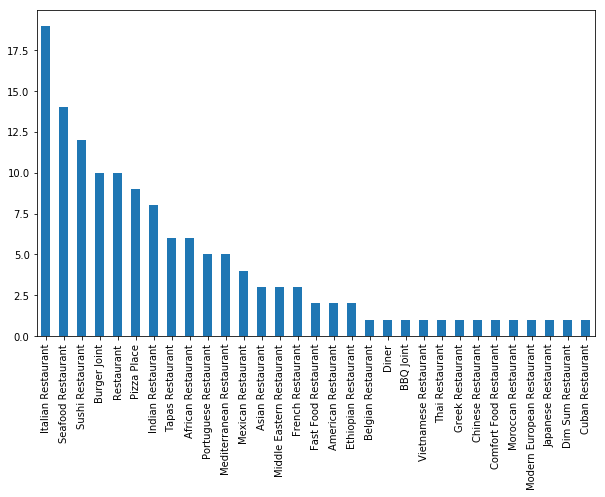

In [330]:
aa = pd.DataFrame(a,columns=['Count'])

aa_sorted = aa.sort_values('Count',ascending=False)

ax = aa_sorted.Count.plot(kind='bar', figsize =(10,6))

plt.show()

List the suburbs and the total number of restaurants in each.

In [331]:
b = cape_town_grouped_r1.sum(axis = 1, skipna = True)
b = pd.DataFrame(b,columns=['Count'])

bb = cape_town_grouped_r1.merge(b,left_index=True,right_index=True)
bb = bb[['Suburb','Count']]
bb = bb.set_index('Suburb')
bb

,Count
Suburb,
Camps Bay,12
Cape Town City Centre,28
De Waterkant,7
Gardens,24
Green Point,12
Sea Point,20
Tamboerskloof,4
Waterfront,29


Create a bar graph.

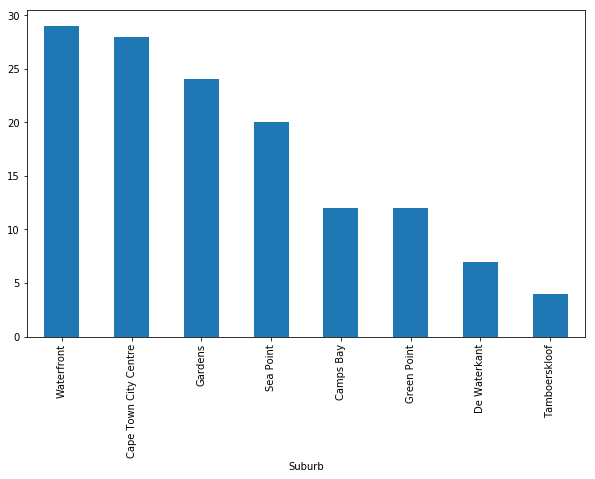

In [332]:
bb_sorted = bb.sort_values('Count',ascending=False)

bx = bb_sorted.Count.plot(kind='bar', figsize =(10,6))

plt.show()

### Most common restaurant categories

We print each suburb along with the top 10 most common restaurant categories.

In [333]:
num_top_venues = 10

for sub in cape_town_grouped_r1['Suburb']:
    print("----"+sub+"----")
    temp = cape_town_grouped_r1[cape_town_grouped_r1['Suburb'] == sub].T.reset_index()
    temp.columns = ['venue','count']
    temp = temp.iloc[1:]
    #temp['count'] = temp['count'].astype(float)
    #temp = temp.round({'count': 2})
    print(temp.sort_values('count', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Camps Bay----
                        venue count
0          Seafood Restaurant     3
1                  Restaurant     3
2          Mexican Restaurant     1
3         American Restaurant     1
4         Japanese Restaurant     1
5          Italian Restaurant     1
6           Indian Restaurant     1
7                 Pizza Place     1
8            Sushi Restaurant     0
9  Modern European Restaurant     0


----Cape Town City Centre----
                  venue count
0    Italian Restaurant     4
1     Indian Restaurant     4
2          Burger Joint     3
3    African Restaurant     2
4  Ethiopian Restaurant     2
5      Tapas Restaurant     2
6      Sushi Restaurant     2
7            Restaurant     2
8           Pizza Place     2
9    Dim Sum Restaurant     1


----De Waterkant----
                       venue count
0         African Restaurant     2
1           Sushi Restaurant     2
2         Seafood Restaurant     1
3         Italian Restaurant     1
4  Middle Eastern Restaura

We create a new dataset that displays the top 5 restaurants for each suburb.

In [374]:
# Function that sorts the venues in descending order
def return_most_common_restaurants(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = cape_town_grouped_r1['Suburb']

for ind in np.arange(cape_town_grouped_r1.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_restaurants(cape_town_grouped_r1.iloc[ind, :], num_top_venues)

suburbs_venues_sorted

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Camps Bay,Restaurant,Seafood Restaurant,Japanese Restaurant,Mexican Restaurant,Indian Restaurant
1,Cape Town City Centre,Indian Restaurant,Italian Restaurant,Burger Joint,Pizza Place,Sushi Restaurant
2,De Waterkant,African Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Italian Restaurant,Seafood Restaurant
3,Gardens,Italian Restaurant,Pizza Place,Portuguese Restaurant,French Restaurant,Indian Restaurant
4,Green Point,Sushi Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Cuban Restaurant
5,Sea Point,Sushi Restaurant,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Restaurant
6,Tamboerskloof,Asian Restaurant,Comfort Food Restaurant,Seafood Restaurant,Italian Restaurant,Pizza Place
7,Waterfront,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Mediterranean Restaurant,Restaurant


### Clustering the suburbs

We run *k*-means to cluster the suburbs into 4 clusters.

In [375]:
k = 4

grouped_clustering = cape_town_grouped_r1.drop('Suburb', 1)

kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)

kmeans.labels_[0:10] 

array([1, 2, 1, 2, 1, 3, 1, 0])

New dataset that includes the cluster column as well as the top 5 restaurant categories.

In [376]:
suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cape_town_merged = cape_town

cape_town_merged = cape_town_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='Suburb')

cape_town_merged

,Suburb,Street Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cape Town City Centre,8000,-33.921716,18.420122,2,Indian Restaurant,Italian Restaurant,Burger Joint,Pizza Place,Sushi Restaurant
1,Waterfront,8001,-33.903261,18.421081,0,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Mediterranean Restaurant,Restaurant
2,Gardens,8001,-33.933895,18.407657,2,Italian Restaurant,Pizza Place,Portuguese Restaurant,French Restaurant,Indian Restaurant
3,De Waterkant,8001,-33.915310,18.419493,1,African Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Italian Restaurant,Seafood Restaurant
4,Tamboerskloof,8001,-33.928333,18.406389,1,Asian Restaurant,Comfort Food Restaurant,Seafood Restaurant,Italian Restaurant,Pizza Place
5,Camps Bay,8005,-33.951172,18.378458,1,Restaurant,Seafood Restaurant,Japanese Restaurant,Mexican Restaurant,Indian Restaurant
6,Sea Point,8005,-33.916303,18.389307,3,Sushi Restaurant,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Restaurant
7,Green Point,8051,-33.905870,18.409143,1,Sushi Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Cuban Restaurant


We will now visualize the resulting clusters.

In [384]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(cape_town_merged['Latitude'], cape_town_merged['Longitude'], cape_town_merged['Suburb'], cape_town_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the clusters

We list the different clusters to see how they differentiate from each other.

#### Cluster 0

In [378]:
cape_town_merged.loc[cape_town_merged['Cluster Labels'] == 0, cape_town_merged.columns[[0] + list(range(5, cape_town_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Waterfront,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Mediterranean Restaurant,Restaurant


#### Cluster 1

In [379]:
cape_town_merged.loc[cape_town_merged['Cluster Labels'] == 1, cape_town_merged.columns[[0] + list(range(5, cape_town_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,De Waterkant,African Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Italian Restaurant,Seafood Restaurant
4,Tamboerskloof,Asian Restaurant,Comfort Food Restaurant,Seafood Restaurant,Italian Restaurant,Pizza Place
5,Camps Bay,Restaurant,Seafood Restaurant,Japanese Restaurant,Mexican Restaurant,Indian Restaurant
7,Green Point,Sushi Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Cuban Restaurant


#### Cluster 2

In [380]:
cape_town_merged.loc[cape_town_merged['Cluster Labels'] == 2, cape_town_merged.columns[[0] + list(range(5, cape_town_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cape Town City Centre,Indian Restaurant,Italian Restaurant,Burger Joint,Pizza Place,Sushi Restaurant
2,Gardens,Italian Restaurant,Pizza Place,Portuguese Restaurant,French Restaurant,Indian Restaurant


#### Cluster 3

In [381]:
cape_town_merged.loc[cape_town_merged['Cluster Labels'] == 3, cape_town_merged.columns[[0] + list(range(5, cape_town_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Sea Point,Sushi Restaurant,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Restaurant
